In [ ]:
import requests
from bs4 import BeautifulSoup

page = 1
while page <= 31:
    url = f'https://www.r-ulybka.ru/u-catalog/litso/dlya-ukhoda/?PAGEN_1={page}'
    response = requests.get(url)

    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')

        product_cards = soup.find_all('a', class_='prod-item')  # Находим все карточки товаров на странице

        with open('парсинг1.txt', 'a', encoding='utf-8') as file:  # Используем 'a' для добавления в файл
            for card in product_cards:
                product_url = 'https://www.r-ulybka.ru' + card['href']  # Получаем ссылку на каждый товар
                product_name = card.find('span', class_='name').text.strip()  # Извлекаем название товара
                product_price = card.find('span', class_='new-price').text.strip()  # Извлекаем цену товара
                img_src = card.find('img')['src']  # Получаем ссылку на изображение товара

                file.write(f"Ссылка на товар: {product_url}\n")
                file.write(f"Название товара: {product_name}\n")
                file.write(f"Цена: {product_price}\n")
                file.write(f"Ссылка на изображение: {img_src}\n")
                file.write('\n')
    else:
        print(f"Ошибка при получении страницы {url}")

    page += 1

In [ ]:
import requests
from bs4 import BeautifulSoup

# Читаем данные из файла
with open('парсинг1.txt', 'r', encoding='utf-8') as file:
    lines = file.readlines()

# Переходим по каждой ссылке и получаем состав продукта
with open('парсинг2.txt', 'w', encoding='utf-8') as output_file:
    for line in lines:
        if line.startswith('Ссылка на товар:'):
            url = line[len('Ссылка на товар:'):].strip()
            url += '#product-description'  # добавляем #product-description к URL
            response = requests.get(url)
            if response.status_code == 200:
                soup = BeautifulSoup(response.content, 'html.parser')
                title = soup.title.text.strip()
                composition_section = soup.find('p', class_='ttl', string='Состав:')
                if composition_section:
                    composition = composition_section.find_next('p').get_text()
                    output_file.write(f"URL: {url}\n")
                    output_file.write(f"Title: {title}\n")
                    output_file.write(f"Состав: {composition}\n\n")
                else:
                    output_file.write(f"На странице {url} отсутствует информация о составе\n\n")
            else:
                output_file.write(f"Ошибка при получении страницы товара {url}\n\n")

In [ ]:
import requests
from bs4 import BeautifulSoup

# Читаем данные из файла
with open('парсинг1.txt', 'r', encoding='utf-8') as file:
    lines = file.readlines()

# Переходим по каждой ссылке и получаем заголовки
updated_lines = []
product_name = ""
for line in lines:
    updated_lines.append(line)
    if line.startswith('Название товара:'):
        product_name = line[len('Название товара:'):].strip()
    elif line.startswith('Ссылка на товар:'):
        url = line[len('Ссылка на товар:'):].strip()  # Обрезаем пробелы и ненужные символы
        url += '#product-properties'
        if url.endswith(':'):
            url = url[:-1]  # Убираем последний символ двоеточия, если он есть
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, 'html.parser')
            print("Webpage content:")  # Добавляем для отладки
            print(soup.prettify())  # Добавляем для отладки
            props_section = soup.find('div', id='product-properties')
            if props_section:
                dimensions = props_section.find_all('span', class_='val')
                if dimensions:
                    weight = width = length = height = 'Нет данных'

                    for dimension in dimensions:
                        name = dimension.find_previous_sibling('span', class_='name').get_text()
                        value = dimension.get_text()
                        if 'Вес' in name:
                            weight = value
                        elif 'Ширина' in name:
                            width = value
                        elif 'Длина' in name:
                            length = value
                        elif 'Высота' in name:
                            height = value

                    updated_lines.append(f"Вес: {weight}\n")
                    updated_lines.append(f"Ширина: {width}\n")
                    updated_lines.append(f"Длина: {length}\n")
                    updated_lines.append(f"Высота: {height}\n")
                else:
                    updated_lines.append("На странице недостаточно элементов для извлечения размеров\n")
            else:
                updated_lines.append("На странице нет раздела с характеристиками\n")
        else:
            updated_lines.append(f"Ошибка при получении страницы товара {url}\n")

# Записываем обновленные данные обратно в файл
with open('парсинг1.txt', 'w', encoding='utf-8') as file:
    file.writelines(updated_lines)


In [13]:
# Читаем данные из файла и считаем количество строк с "Название товара"
with open('парсинг1.txt', 'r', encoding='utf-8') as file:
    lines = file.readlines()

# Подсчет количества строк, содержащих "Название товара"
count = sum(1 for line in lines if "Название товара" in line)

print(f'Количество вхождений строки "Название товара": {count}')


Количество вхождений строки "Название товара": 3458


In [14]:
def read_file(filepath):
    with open(filepath, 'r', encoding='utf-8') as file:
        return file.read()

def find_duplicates(content):
    products = content.split('\n\n')
    product_set = set()
    duplicates = set()

    for product in products:
        product_lines = product.strip().split('\n')
        if len(product_lines) > 1:
            product_info = "\n".join(product_lines[1:])  # Exclude the URL line
            if product_info in product_set:
                duplicates.add(product_info)
            else:
                product_set.add(product_info)
    
    return duplicates

def main():
    filepath = 'парсинг1.txt'
    content = read_file(filepath)
    duplicates = find_duplicates(content)
    
    if duplicates:
        print("Повторяющиеся элементы:")
        for duplicate in duplicates:
            print(f"\n{duplicate}\n")
    else:
        print("Повторяющихся элементов не найдено.")

if __name__ == "__main__":
    main()


Повторяющиеся элементы:

Вес: 40г
Ширина: 4,5см
Длина: 4,5см
Высота: 3,4см
Вес: 40г
Ширина: 4,5см
Длина: 4,5см
Высота: 3,4см
Название товара: Крем для лица и рук Delicare Soft Cream " Гладкость " с экстрактом розы 30мл
Цена: 79 ₽


Вес: 34г
Ширина: 10см
Длина: 16,5см
Высота: 0,6см
Вес: 34г
Ширина: 10см
Длина: 16,5см
Высота: 0,6см
Название товара: Маска Vilenta 7 Days для лица во время просмотра сериала , с белым чаем и грушей  " Лёгкая среда " , для всех типов кожи 28мл
Цена: 95 ₽


Вес: 128г
Ширина: 3,8см
Длина: 3,8см
Высота: 14,5см
Вес: 128г
Ширина: 3,8см
Длина: 3,8см
Высота: 14,5см
Название товара: Увлажняющая Эссенция - тонер для лица Botaniqua с гиалуроном и авокадо 100мл
Цена: 119 ₽


Вес: 205г
Ширина: 7см
Длина: 7см
Высота: 6см
Вес: 205г
Ширина: 7см
Длина: 7см
Высота: 6см
Название товара: Дневной крем L`Oreal Paris Возраст Эксперт для лица против морщин 55+ 50мл
Цена: 486 ₽


Вес: 122г
Ширина: 7см
Длина: 7см
Высота: 6,5см
Вес: 122г
Ширина: 7см
Длина: 7см
Высота: 6,5см
Название т

In [19]:
def read_file(filepath):
    with open(filepath, 'r', encoding='utf-8') as file:
        return file.read()

def remove_duplicates(content):
    products = content.split('\n\n')
    product_set = set()
    unique_products = []

    for product in products:
        product_lines = product.strip().split('\n')
        if len(product_lines) > 1:
            # Убедимся, что параметры не повторяются
            seen_params = set()
            unique_lines = []

            for line in product_lines:
                param_name = line.split(':')[0]
                if param_name not in seen_params:
                    unique_lines.append(line)
                    seen_params.add(param_name)

            product_info = "\n".join(unique_lines[1:])  # Exclude the URL line
            if product_info not in product_set:
                product_set.add(product_info)
                unique_products.append("\n".join(unique_lines))
    
    return "\n\n".join(unique_products)

def write_file(filepath, content):
    with open(filepath, 'w', encoding='utf-8') as file:
        file.write(content)

def main():
    input_filepath = 'парсинг1.txt'
    output_filepath = 'парсинг1_уникальные.txt'

    content = read_file(input_filepath)
    unique_content = remove_duplicates(content)
    write_file(output_filepath, unique_content)

    print(f"Обработанный файл сохранен как {output_filepath}")

if __name__ == "__main__":
    main()


Обработанный файл сохранен как парсинг1_уникальные.txt


In [20]:
# Читаем данные из файла и считаем количество строк с "Название товара"
with open('парсинг1_уникальные.txt', 'r', encoding='utf-8') as file:
    lines = file.readlines()

# Подсчет количества строк, содержащих "Название товара"
count = sum(1 for line in lines if "Название товара" in line)

print(f'Количество вхождений строки "Название товара": {count}')


Количество вхождений строки "Название товара": 1288


In [21]:
import re

# Инициализация списков для веса и цены
weights = []
prices = []

# Переменные для хранения текущего веса и цены
current_weight = None
current_price = None

# Парсинг данных из каждой строки файла
for line in lines:
    # Проверка наличия информации о весе в строке
    if line.startswith('Вес:'):
        # Извлечение веса из строки
        match = re.search(r'Вес: (\d+)', line)
        if match:
            current_weight = float(match.group(1))
        else:
            print("Ошибка парсинга веса в строке:", line)
    # Проверка наличия информации о цене в строке
    elif line.startswith('Цена:'):
        # Извлечение цены из строки
        match = re.search(r'Цена: (\d+)', line)
        if match:
            current_price = float(match.group(1))
            # Добавляем вес и цену в списки
            weights.append(current_weight)
            prices.append(current_price)
        else:
            print("Ошибка парсинга цены в строке:", line)

# Вывод размеров списков
print("Размер списка weights:", len(weights))
print("Размер списка prices:", len(prices))


Размер списка weights: 1288
Размер списка prices: 1288


In [ ]:
График "Зависимости цены от веса":

Ось X: Вес товара
Ось Y: Цена товара
Это позволит увидеть, как цена товара зависит от его веса.

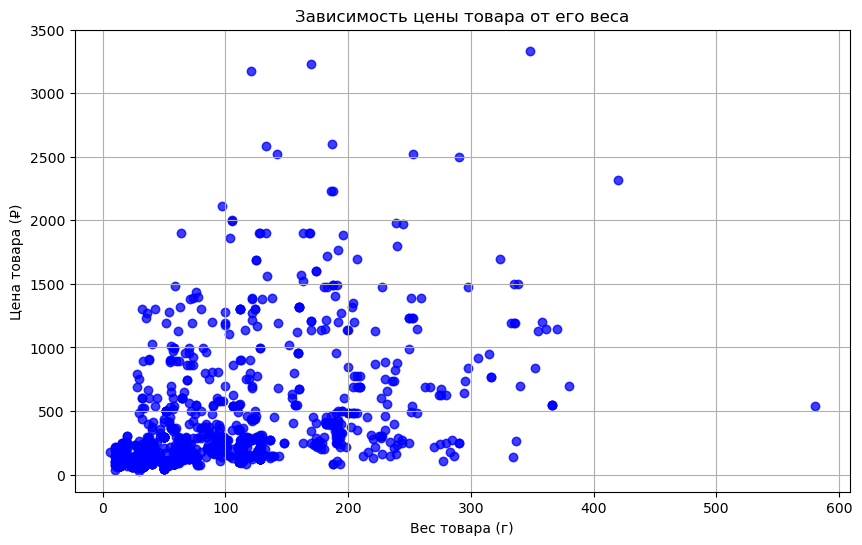

In [6]:
import matplotlib.pyplot as plt

# Создание графика
plt.figure(figsize=(10, 6))
plt.scatter(weights, prices, color='blue', alpha=0.5)

# Настройка графика
plt.title('Зависимость цены товара от его веса')
plt.xlabel('Вес товара (г)')
plt.ylabel('Цена товара (₽)')
plt.grid(True)

# Отображение графика
plt.show()


In [ ]:
График "цена против объема":

Ось X: Объем товара (рассчитанный как ширина * длина * высота)
Ось Y: Цена товара
Этот график поможет понять, есть ли зависимость между ценой товара и его объемом.

In [37]:
import re

# Инициализация списков для ширины, длины и высоты
widths = []
lengths = []
heights = []

# Переменные для хранения текущей ширины, длины и высоты
current_width = None
current_length = None
current_height = None

# Парсинг данных из каждой строки файла
for line in lines:
    # Проверка наличия информации о ширине в строке
    if line.startswith('Ширина:'):
        # Извлечение ширины из строки
        match = re.search(r'Ширина: ([\d,]+)см', line)
        if match:
            current_width = float(match.group(1).replace(',', '.'))
        else:
            print("Ошибка парсинга ширины в строке:", line)
    # Проверка наличия информации о длине в строке
    elif line.startswith('Длина:'):
        # Извлечение длины из строки
        match = re.search(r'Длина: ([\d,]+)см', line)
        if match:
            current_length = float(match.group(1).replace(',', '.'))
        else:
            print("Ошибка парсинга длины в строке:", line)
    # Проверка наличия информации о высоте в строке
    elif line.startswith('Высота:'):
        # Извлечение высоты из строки
        match = re.search(r'Высота: ([\d,]+)см', line)
        if match:
            current_height = float(match.group(1).replace(',', '.'))
            # Добавляем в списки, если все три параметра присутствуют
            if current_width is not None and current_length is not None and current_height is not None:
                widths.append(current_width)
                lengths.append(current_length)
                heights.append(current_height)
                current_width = current_length = current_height = None
        else:
            print("Ошибка парсинга высоты в строке:", line)

# Вывод размеров списков
print("Размер списка widths:", len(widths))
print("Размер списка lengths:", len(lengths))
print("Размер списка heights:", len(heights))


Размер списка widths: 1288
Размер списка lengths: 1288
Размер списка heights: 1288


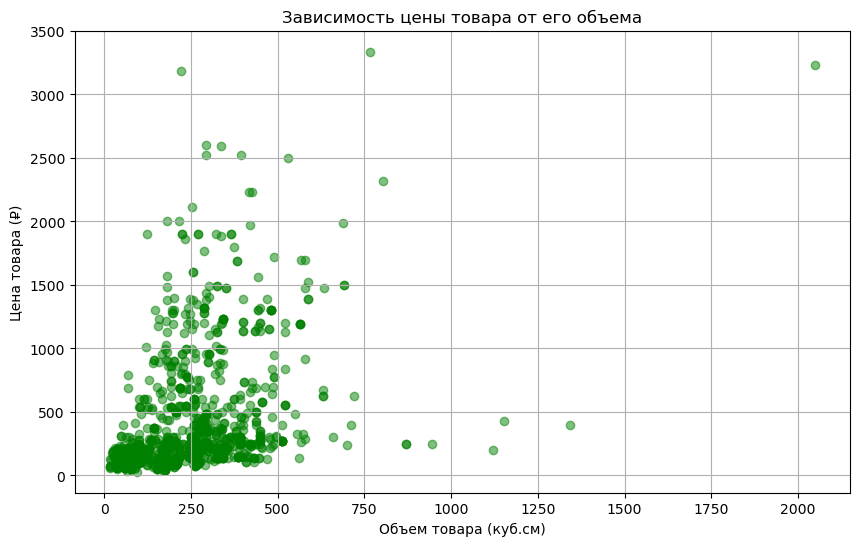

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Предположим, у нас есть списки weights, prices, heights, widths, lengths и names

# Рассчитаем объемы товаров
volumes = [w * l * h for w, l, h in zip(widths, lengths, heights)]

# График "цена против объема"
plt.figure(figsize=(10, 6))
plt.scatter(volumes, prices, color='green', alpha=0.5)
plt.title('Зависимость цены товара от его объема')
plt.xlabel('Объем товара (куб.см)')
plt.ylabel('Цена товара (₽)')
plt.grid(True)
plt.show()



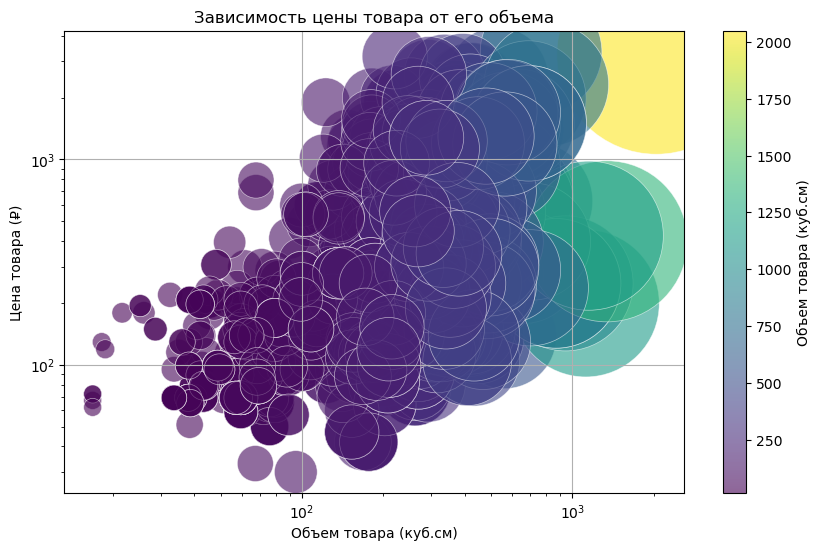

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Рассчитаем объемы товаров
volumes = [w * l * h for w, l, h in zip(widths, lengths, heights)]

# График "цена против объема" с логарифмическими шкалами
plt.figure(figsize=(10, 6))

# Используем объемы товаров для определения размера точек
sizes = np.array(volumes) * 10  # Увеличиваем размеры точек для лучшей видимости

scatter = plt.scatter(volumes, prices, s=sizes, c=volumes, cmap='viridis', alpha=0.6, edgecolors='w', linewidth=0.5)
plt.colorbar(scatter, label='Объем товара (куб.см)')

plt.title('Зависимость цены товара от его объема')
plt.xlabel('Объем товара (куб.см)')
plt.ylabel('Цена товара (₽)')
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.show()


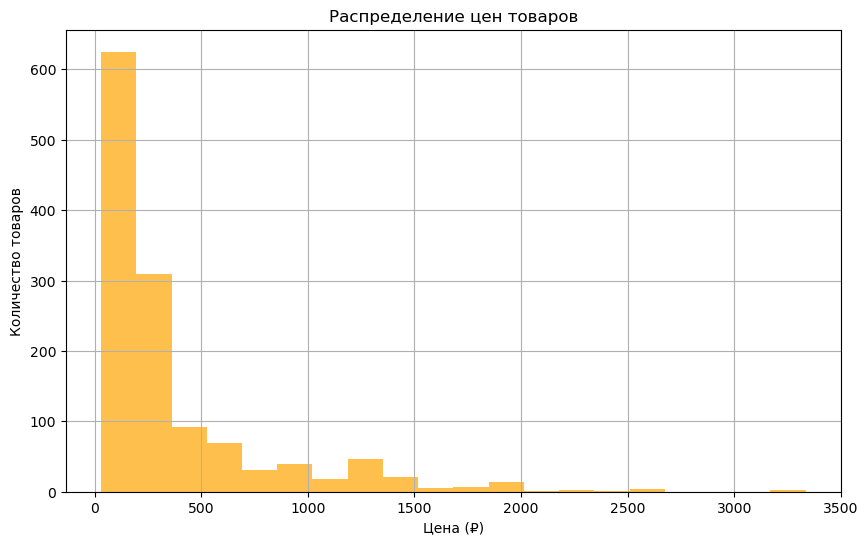

In [41]:
# Гистограмма цен
plt.figure(figsize=(10, 6))
plt.hist(prices, bins=20, color='orange', alpha=0.7)
plt.title('Распределение цен товаров')
plt.xlabel('Цена (₽)')
plt.ylabel('Количество товаров')
plt.grid(True)
plt.show()


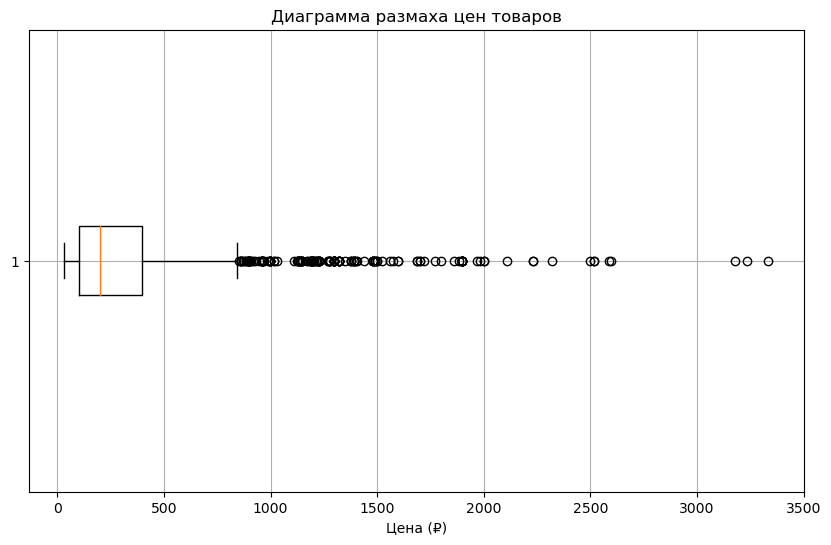

In [43]:
# Диаграмма размаха (box plot) для цен
plt.figure(figsize=(10, 6))
plt.boxplot(prices, vert=False)
plt.title('Диаграмма размаха цен товаров')
plt.xlabel('Цена (₽)')
plt.grid(True)
plt.show()

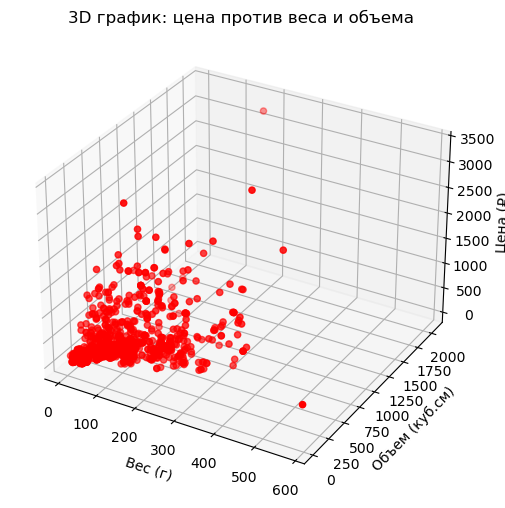

In [44]:
# 3D график
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(weights, volumes, prices, c='r', marker='o')
ax.set_xlabel('Вес (г)')
ax.set_ylabel('Объем (куб.см)')
ax.set_zlabel('Цена (₽)')
plt.title('3D график: цена против веса и объема')
plt.show()